In [66]:
from pathlib import Path
from sm.prelude import M
import orjson, ormsgpack, timeit, os, gzip, msgpack, random, seaborn as sns, pandas as pd
from tqdm import tqdm

In [3]:
indir = Path("./data/wikidata/20211213/entity_dumps/").absolute()
testfile = str(list(indir.glob("*.ndjson.gz"))[0])

In [6]:
content = M.deserialize_jl(testfile)

In [19]:
with M.Timer().watch_and_report("orjson dumps"):
    orj = orjson.dumps(content)
print("dump size", M.datasize(len(orj)))

with M.Timer().watch_and_report("orjson gzip compress"):
    compressed_orj = gzip.compress(orj)
print("compress dump size", M.datasize(len(compressed_orj)))

with M.Timer().watch_and_report("orjson gzip decompress"):
    decompressed_orj = gzip.decompress(compressed_orj)

with M.Timer().watch_and_report("orjson loads"):
    origin_content = orjson.loads(orj)

orjson dumps: 5.394 seconds
dump size 774.0MiB
orjson gzip compress: 34.181 seconds
compress dump size 112.3MiB
orjson gzip decompress: 3.917 seconds
orjson loads: 73.469 seconds


In [21]:
with M.Timer().watch_and_report("ormsgpack dumps"):
    ormp = ormsgpack.packb(content)
print("dump size", M.datasize(len(ormp)))

with M.Timer().watch_and_report("ormsgpack gzip compress"):
    compressed_ormp = gzip.compress(ormp)
print("compress dump size", M.datasize(len(compressed_ormp)))

with M.Timer().watch_and_report("ormsgpack gzip decompress"):
    decompressed_ormp = gzip.decompress(compressed_ormp)

with M.Timer().watch_and_report("ormsgpack loads"):
    origin_content = ormsgpack.unpackb(ormp)

ormsgpack dumps: 6.017 seconds
dump size 629.7MiB
ormsgpack gzip compress: 23.454 seconds
compress dump size 114.5MiB
ormsgpack gzip decompress: 3.577 seconds
ormsgpack loads: 46.053 seconds


In [22]:
with M.Timer().watch_and_report("msgpack dumps"):
    mp = msgpack.packb(content)
print("dump size", M.datasize(len(mp)))

with M.Timer().watch_and_report("msgpack gzip compress"):
    compressed_mp = gzip.compress(mp)
print("compress dump size", M.datasize(len(compressed_mp)))

with M.Timer().watch_and_report("msgpack gzip decompress"):
    decompressed_mp = gzip.decompress(compressed_mp)

with M.Timer().watch_and_report("msgpack loads"):
    origin_content = msgpack.unpackb(mp)

msgpack dumps: 9.157 seconds
dump size 629.7MiB
msgpack gzip compress: 22.028 seconds
compress dump size 114.5MiB
msgpack gzip decompress: 3.397 seconds
msgpack loads: 73.103 seconds


proper test

In [33]:
M.serialize_jl(random.sample(content, 1000), "/tmp/serde_benchmark.ndjson")
M.datasize(len(M.deserialize_bytes("/tmp/serde_benchmark.ndjson")))

'11.8MiB'

In [59]:
def get_setup(dumps, loads):
    return f"""
from sm.misc import deserialize_jl, deserialize_text
from gzip import compress, decompress
{dumps} as dumps
{loads} as loads

data = deserialize_jl("/tmp/serde_benchmark.ndjson")
serdata = dumps(data)
compressed_serdata = compress(serdata if isinstance(serdata, bytes) else serdata.encode())
serdata_row = [dumps(row) for row in data]
compressed_serdata_row = [compress(row if isinstance(row, bytes) else row.encode()) for row in serdata_row]
    """


test_dump = "dumps(data)"
test_load = "loads(serdata)"
test_dump_compress = "compress(dumps(data))"
test_load_decompress = "loads(decompress(compressed_serdata))"
test_dump_example = "[dumps(row) for row in data]"
test_load_example = "[loads(row) for row in serdata_row]"
test_dump_example_compress = "[compress(dumps(row)) for row in data]"
test_load_example_decompress = "[loads(decompress(row)) for row in compressed_serdata_row]"

config = {
    "orjson": [
        "from orjson import dumps",
        "from orjson import loads"
    ],
    "ormsgpack": [
        "from ormsgpack import packb",
        "from ormsgpack import unpackb"
    ],
    "msgpack": [
        "from msgpack import packb",
        "from msgpack import unpackb"
    ]
}

In [62]:
runtime = []
verbose = False
n = 5

for i in tqdm(range(20)):
    for method, (dumps, loads) in config.items():
        row = {"method": method}
        time = timeit.timeit(test_dump, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- dumps:', time)
        runtime.append({"method": method, "time": time, "test": 'dumps'})
        time = timeit.timeit(test_load, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- loads:', time)
        runtime.append({"method": method, "time": time, "test": 'loads'})
        time = timeit.timeit(test_dump_compress, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- compressed dumps:', time)
        runtime.append({"method": method, "time": time, "test": 'compressed dumps'})
        time = timeit.timeit(test_load_decompress, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- compressed loads:', time)
        runtime.append({"method": method, "time": time, "test": 'compressed loads'})
        time = timeit.timeit(test_dump_example, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- example dumps:', time)
        runtime.append({"method": method, "time": time, "test": 'example dumps'})
        time = timeit.timeit(test_load_example, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- example loads:', time)
        runtime.append({"method": method, "time": time, "test": 'example loads'})
        time = timeit.timeit(test_dump_example_compress, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- compressed example dumps:', time)
        runtime.append({"method": method, "time": time, "test": 'compressed example dumps'})
        time = timeit.timeit(test_load_example_decompress, setup=get_setup(dumps, loads), number=n)
        if verbose: print(f'method: {method} -- compressed example loads:', time)
        runtime.append({"method": method, "time": time, "test": 'compressed example loads'})

100%|██████████| 20/20 [14:18<00:00, 42.93s/it]


<AxesSubplot:xlabel='test', ylabel='time'>

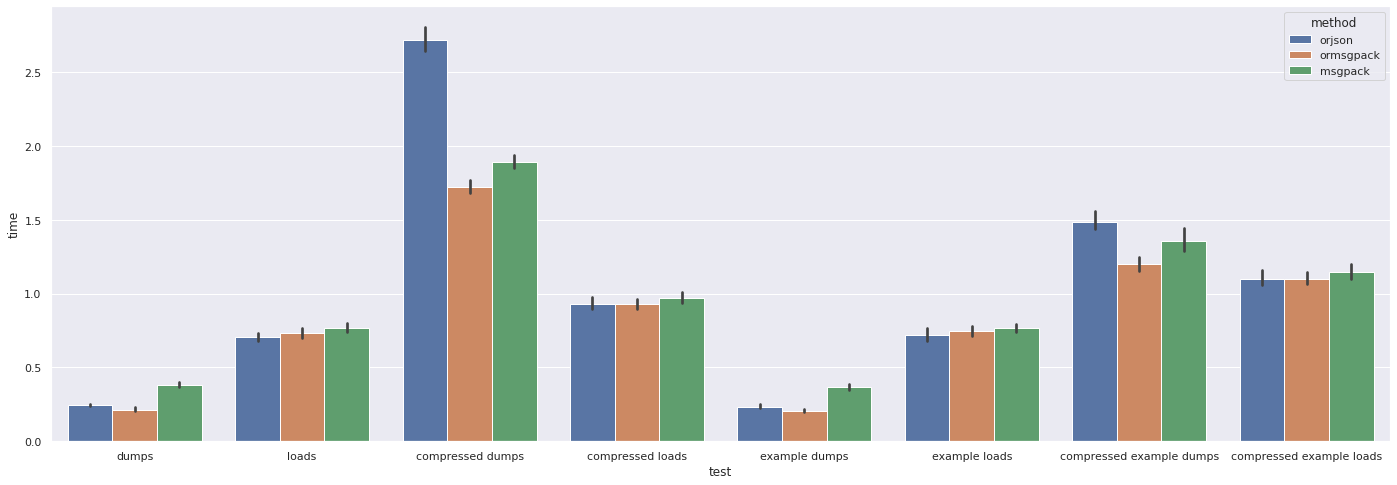

In [71]:
sns.set(rc={'figure.figsize':(24,8)})
sns.barplot(x='test', y='time', hue='method', data=pd.DataFrame(runtime))

In [76]:
for row in runtime[:20]:
    print("method:", row['method'], 'test:', row['test'], 'time:', row['time'])

method: orjson test: dumps time: 0.31075817346572876
method: orjson test: loads time: 0.7803415730595589
method: orjson test: compressed dumps time: 3.059521660208702
method: orjson test: compressed loads time: 1.1748670861124992
method: orjson test: example dumps time: 0.3518572151660919
method: orjson test: example loads time: 1.0279078111052513
method: orjson test: compressed example dumps time: 2.001990132033825
method: orjson test: compressed example loads time: 1.1755687966942787
method: ormsgpack test: dumps time: 0.29764970391988754
method: ormsgpack test: loads time: 0.9337270110845566
method: ormsgpack test: compressed dumps time: 1.7572860047221184
method: ormsgpack test: compressed loads time: 1.0985396727919579
method: ormsgpack test: example dumps time: 0.2406771406531334
method: ormsgpack test: example loads time: 0.8291367143392563
method: ormsgpack test: compressed example dumps time: 1.4327634945511818
method: ormsgpack test: compressed example loads time: 1.181354984

In [58]:
data = M.deserialize_jl("/tmp/serde_benchmark.ndjson")

print("orjson size", M.datasize(sum([len(orjson.dumps(row)) for row in data])))
print("ormsgpack size", M.datasize(sum([len(ormsgpack.packb(row)) for row in data])))
print("orjson compressed size", M.datasize(sum([len(gzip.compress(orjson.dumps(row))) for row in data])))
print("ormsgpack compressed size", M.datasize(sum([len(gzip.compress(ormsgpack.packb(row))) for row in data])))

orjson size 11.8MiB
ormsgpack size 9.6MiB
orjson compressed size 2.3MiB
ormsgpack compressed size 2.4MiB
